In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

C:\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('data_filtered_rand.csv')

In [3]:
df

,date,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight,pond,feed_amount,fish_biomass,feed_ratio
0,01-07-2021,24.8125,96.0,15.002,7.58477,0.72440,92.0,NaN,10.754286,11.502857,Pond 9,0.287571,10.000714,2.875509
1,29-06-2021,24.6875,100.0,6.880,7.92976,0.38000,117.0,50.0,10.460000,10.360000,Pond 2,0.259000,9.151060,2.830273
2,24-06-2021,25.0625,100.0,17.044,8.20213,0.38000,143.0,50.0,8.710000,6.860000,Pond 2,0.171500,5.093638,3.366945
3,16-08-2021,24.9375,35.0,16.439,7.04457,0.56293,978.0,NaN,23.788571,143.542857,Pond 7,3.588571,126.867027,2.828608
4,15-08-2021,24.5625,100.0,1.056,7.60292,0.00007,1799.0,75.0,25.630000,163.360000,Pond 4,4.084000,161.051786,2.535830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379583,28-06-2021,24.3125,85.0,20.834,7.68463,0.53592,93.0,NaN,9.875714,9.857143,Pond 9,0.246429,7.613586,3.236695
379584,19-06-2021,26.3125,100.0,11.909,8.40641,0.45842,202.0,50.0,7.110000,2.910000,Pond 1,0.072750,2.660435,2.734515
379585,14-08-2021,23.2500,100.0,5.080,7.31694,0.23018,742.0,50.0,20.310000,49.300000,Pond 3,1.232500,76.496534,1.611184
379586,23-07-2021,23.8750,100.0,11.149,6.73135,0.23756,896.0,75.0,17.520000,49.430000,Pond 6,1.235750,47.673730,2.592098


In [4]:
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))

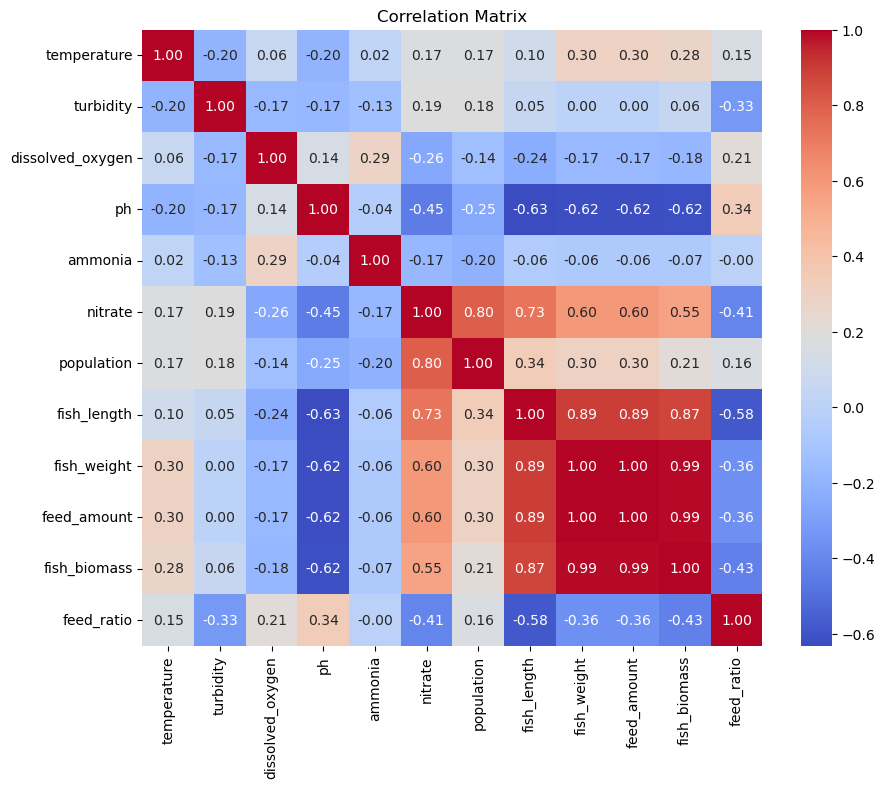

In [5]:
correlation_matrix =df.drop(columns={'pond','date'}).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [6]:
df.columns

Index(['date', 'temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia',
       'nitrate', 'population', 'fish_length', 'fish_weight', 'pond',
       'feed_amount', 'fish_biomass', 'feed_ratio'],
      dtype='object')

## Ammonia Use Case (Weight Prediction)

In [9]:
ammonia_data = df[['temperature','dissolved_oxygen','ph','fish_weight','ammonia']]

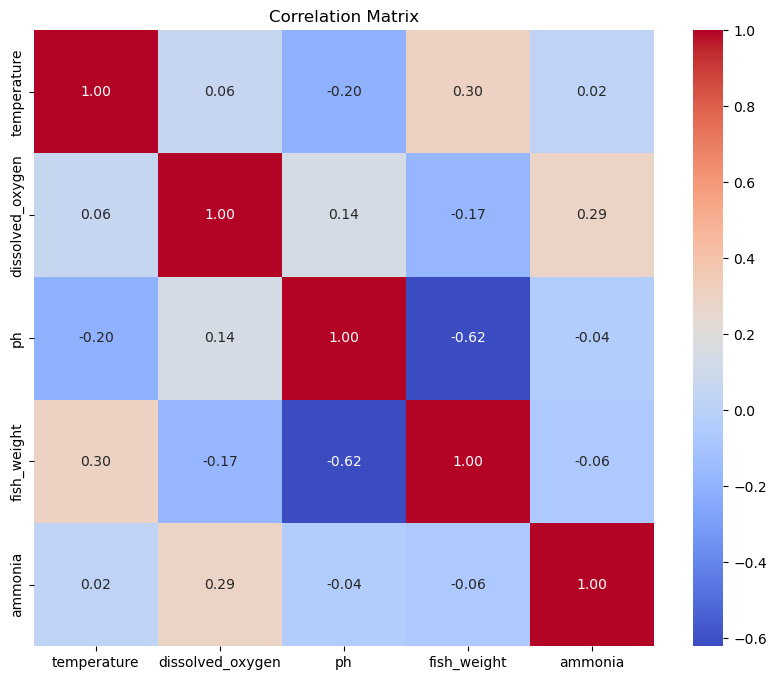

In [10]:
correlation_matrix = ammonia_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [11]:
ammonia_data.shape

(379588, 5)

In [12]:
unseen_ammonia_data = ammonia_data.tail(79588)

ammonia_data = ammonia_data.iloc[:-79588]

In [13]:
print(ammonia_data.shape)
print(unseen_ammonia_data.shape)

(300000, 5)
(79588, 5)


In [14]:
X = ammonia_data.drop(columns=['ammonia'])
y = ammonia_data['ammonia']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [16]:
print(X_train.shape)
print(X_test.shape)

(270000, 4)
(30000, 4)


### Linear Regression (Base Model)

In [17]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

LinearRegression()

In [18]:
lr_predictions = lr_model.predict(X_test)

In [19]:
lr_mse = mean_squared_error(y_test, lr_predictions)
print(lr_model.score(X_test, y_test))
print("Mean Squared Error:", lr_mse)

0.0995826774644808
Mean Squared Error: 0.907447413525393


In [20]:
lr_predicted_data = {'Actual': y_test.values, 'Predicted': lr_predictions, 'Difference': y_test.values - lr_predictions}
df_results = pd.DataFrame(lr_predicted_data)

df_results

,Actual,Predicted,Difference
0,0.38000,0.490195,-0.110195
1,0.38000,0.567337,-0.187337
2,0.33749,0.656344,-0.318854
3,1.28654,1.085742,0.200798
4,0.00109,0.318768,-0.317678
...,...,...,...
29995,0.75207,0.641903,0.110167
29996,1.20328,0.485011,0.718269
29997,0.42857,0.997733,-0.569163
29998,0.00013,0.189064,-0.188934


In [ ]:
for i in range(len(lr_predictions)):
    print("Predicted:", lr_predictions[i], "Actual:", y_test.iloc[i])

### Random Forest Model

In [21]:
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)

In [22]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [23]:
rf_predictions = rf_model.predict(X_test)

In [24]:
rf_mse = mean_squared_error(y_test, rf_predictions)
print(rf_model.score(X_test, y_test))
print("Random Forest Mean Squared Error:", rf_mse)

0.9120488240304989
Random Forest Mean Squared Error: 0.08863786285818835


In [25]:
rf_predicted_data = {'Actual': y_test.values, 'Predicted': rf_predictions, 'Difference': y_test.values - rf_predictions}
df_results = pd.DataFrame(rf_predicted_data)

df_results

,Actual,Predicted,Difference
0,0.38000,0.380000,4.996004e-16
1,0.38000,0.380000,2.720046e-15
2,0.33749,0.317538,1.995180e-02
3,1.28654,1.384965,-9.842540e-02
4,0.00109,0.001086,3.895809e-06
...,...,...,...
29995,0.75207,0.819180,-6.711000e-02
29996,1.20328,1.037200,1.660802e-01
29997,0.42857,0.290516,1.380542e-01
29998,0.00013,0.000121,9.200000e-06


In [26]:
for i in range(len(rf_predictions)):
    print("Predicted:", rf_predictions[i], "Actual:", y_test.iloc[i])

Predicted: 0.3799999999999995 Actual: 0.38
Predicted: 0.3799999999999973 Actual: 0.38
Predicted: 0.31753820000000016 Actual: 0.33749
Predicted: 1.3849653999999998 Actual: 1.28654
Predicted: 0.0010861041908091906 Actual: 0.00109
Predicted: 0.10459780000000002 Actual: 0.41059
Predicted: 0.9179828000000001 Actual: 1.07145
Predicted: 0.38975154 Actual: 0.38766
Predicted: 3.012668806666667 Actual: 2.43849
Predicted: 0.5011988360618664 Actual: 0.48893
Predicted: 0.0011706 Actual: 0.00144
Predicted: 0.00015998999999999986 Actual: 0.00014
Predicted: 0.005853415099900099 Actual: 0.00593
Predicted: 0.4584200000000002 Actual: 0.45842
Predicted: 2.500000000000002e-05 Actual: 2e-05
Predicted: 0.4085152 Actual: 0.52927
Predicted: 0.4364212000000001 Actual: 0.38766
Predicted: 3.1200000000000027e-05 Actual: 4e-05
Predicted: 0.5738106000000004 Actual: 0.49303
Predicted: 0.0010376 Actual: 0.00127
Predicted: 0.5139241999999998 Actual: 0.54842
Predicted: 8.460000000000005e-05 Actual: 9e-05
Predicted: 0.00

In [27]:
X_unseen = unseen_ammonia_data.drop(columns=['ammonia'])
y_unseen = unseen_ammonia_data['ammonia']

In [28]:
unseen_predictions = rf_model.predict(X_unseen)

unseen_ammonia_data['predictions'] = unseen_predictions

unseen_ammonia_data

,temperature,dissolved_oxygen,ph,fish_weight,ammonia,predictions
300000,24.1250,0.828,7.47128,59.600000,0.00109,0.001074
300001,24.3125,7.987,7.50306,48.714286,0.00109,0.001101
300002,24.5625,37.511,7.31694,61.690000,4.02950,4.230802
300003,26.2500,0.000,6.58154,164.742857,0.00080,0.001025
300004,27.0000,3.200,3.11793,320.450000,2.38638,1.454192
...,...,...,...,...,...,...
379583,24.3125,20.834,7.68463,9.857143,0.53592,0.405585
379584,26.3125,11.909,8.40641,2.910000,0.45842,0.458420
379585,23.2500,5.080,7.31694,49.300000,0.23018,0.290183
379586,23.8750,11.149,6.73135,49.430000,0.23756,0.821400


In [29]:
unseen_ammonia_data[unseen_ammonia_data['ammonia'] != unseen_ammonia_data['predictions']]

,temperature,dissolved_oxygen,ph,fish_weight,ammonia,predictions
300000,24.1250,0.828,7.47128,59.600000,0.00109,0.001074
300001,24.3125,7.987,7.50306,48.714286,0.00109,0.001101
300002,24.5625,37.511,7.31694,61.690000,4.02950,4.230802
300003,26.2500,0.000,6.58154,164.742857,0.00080,0.001025
300004,27.0000,3.200,3.11793,320.450000,2.38638,1.454192
...,...,...,...,...,...,...
379583,24.3125,20.834,7.68463,9.857143,0.53592,0.405585
379584,26.3125,11.909,8.40641,2.910000,0.45842,0.458420
379585,23.2500,5.080,7.31694,49.300000,0.23018,0.290183
379586,23.8750,11.149,6.73135,49.430000,0.23756,0.821400


In [30]:
unseen_ammonia_data['difference'] = unseen_ammonia_data['ammonia'] - unseen_ammonia_data['predictions']

In [31]:
print(unseen_ammonia_data['difference'].max())
print(unseen_ammonia_data['difference'].min())
print(unseen_ammonia_data['difference'].median())

4.29682
-3.945156000000001
0.0


In [32]:
unseen_ammonia_data[unseen_ammonia_data['difference'] >= 1]

,temperature,dissolved_oxygen,ph,fish_weight,ammonia,predictions,difference
300264,24.3125,0.760,6.88115,145.300000,4.61742,3.462627,1.154793
300332,24.9375,38.669,7.28970,46.500000,4.85101,0.702682,4.148328
300362,25.1250,18.302,7.17167,107.771429,3.92448,2.116056,1.808424
300425,25.5625,3.200,0.31254,254.900000,4.87167,3.381382,1.490288
300514,24.9375,6.009,7.39865,47.710000,4.53072,2.708215,1.822505
...,...,...,...,...,...,...,...
378839,25.3750,10.452,7.14898,126.842857,2.39346,0.655545,1.737915
378861,25.6875,3.200,0.29893,254.900000,3.65935,2.070690,1.588660
378981,24.8750,38.677,7.30786,64.000000,3.10881,1.753154,1.355656
379009,25.1250,3.200,0.12643,264.310000,3.08459,1.723995,1.360595


In [33]:
unseen_ammonia_data[unseen_ammonia_data['difference'] <= -1]

,temperature,dissolved_oxygen,ph,fish_weight,ammonia,predictions,difference
300035,24.2500,23.708,7.30786,24.500000,2.46591,4.215443,-1.749533
300074,27.0000,33.518,7.84805,3.200000,1.44357,3.136371,-1.692801
300193,25.5000,3.200,0.38971,254.900000,1.37598,3.524208,-2.148228
300252,23.7500,14.854,7.12174,49.140000,2.30593,4.075103,-1.769173
300289,23.7500,13.024,7.53483,15.128571,0.27586,1.299440,-1.023580
...,...,...,...,...,...,...,...
379058,24.8750,3.200,0.11735,273.720000,2.56131,4.386616,-1.825306
379269,24.8750,38.745,7.29424,47.960000,1.34021,3.001010,-1.660800
379443,24.8750,38.677,7.29878,64.000000,1.28654,3.643537,-2.356997
379526,26.0625,27.665,7.24431,75.985714,2.86310,3.933475,-1.070375


In [ ]:
# with open('rf_ammonia_model.pkl', 'wb') as file:
#     pickle.dump(rf_model, file)

In [ ]:
# with open('your_trained_model.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)

In [ ]:
unseen_ammonia_data.ph.max()

In [ ]:
unseen_ammonia_data.ph.min()